# Howso Engine &#x2014; Sparse Data and Null Handling

## Overview

This notebook provides an overview of applying Howso Engine to sparse data (i.e., data that contain missing values) and helps to characterize how prediction performance is affected as model sparsity increases.  Howso Engine does not require any preprocessing to handle nulls or NaNs, but has notable robustness when it comes to working with data that contain them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmlb

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

Matplotlib is building the font cache; this may take a moment.


## 1. Load Data

We use the ``adult`` dataset from the [PMLB](https://github.com/EpistasisLab/pmlb) [[1]](#1).

<a id="1">[1]</a>
Joseph D. Romano, Le, Trang T., William La Cava, John T. Gregg, Daniel J. Goldberg, Praneel Chakraborty, Natasha L. Ray, Daniel Himmelstein, 
Weixuan Fu, and Jason H. Moore.  
PMLB v1.0: an open source dataset collection for benchmarking machine learning methods.  
arXiv preprint arXiv:2012.00058 (2020).

In [2]:
df = pmlb.fetch_data("breast_w", local_cache_dir="data/breast_w")

df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,1.0,1.0,1.0,2.0,0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,1,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,0,3.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2,1.0,1.0,1.0,0
695,2.0,1.0,1.0,1.0,2.0,0,1.0,1.0,1.0,0
696,5.0,10.0,10.0,3.0,7.0,3,8.0,10.0,2.0,1
697,4.0,8.0,6.0,4.0,3.0,4,10.0,6.0,1.0,1


Since the datasets in the PMLB have been cleaned, we add nulls into 20% of the dataset here.

In [3]:
null_percent = 0.2
rng = np.random.default_rng()

def insert_percent_nulls(data: pd.DataFrame, percent: float) -> pd.DataFrame:
    data = data.copy(deep=True)
    mask = rng.uniform(size=data.shape) < percent
    data[mask] = None

    return data

null_df = insert_percent_nulls(df, null_percent)
null_df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,NaN,1.0,1.0,2.0,0.0,3.0,1.0,1.0,NaN
1,5.0,4.0,NaN,5.0,7.0,NaN,NaN,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,NaN,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,0.0,3.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,NaN,1.0,0.0
695,2.0,NaN,1.0,1.0,NaN,0.0,1.0,1.0,1.0,0.0
696,5.0,10.0,NaN,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,NaN,10.0,6.0,1.0,NaN


## 2. Infer Feature Attributes

In [4]:
features = infer_feature_attributes(null_df)
features

{'Clump_Thickness': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0}},
 'Cell_Size_Uniformity': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0}},
 'Cell_Shape_Uniformity': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0}},
 'Marginal_Adhesion': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0}},
 'Single_Epi_Cell_Size': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 20.0}},
 'Bare_Nuclei': {'type': 'continuous',
  'decimal_places': 0,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.0, 'max': 20.0}},
 'Bland_Chroma

## 3. Train & Analyze Data

We then train the data into a `Trainee` and analyze the data to determine the best hyperparameters.  Note that we are explicitly declaring our default context and action features.

In [5]:
action_features = ["target"]
context_features = features.get_names(without=action_features)

t = Trainee(features=features, default_action_features=action_features, default_context_features=context_features)
t.train(null_df)
t.analyze(context_features=context_features, action_features=action_features)

## 4. Get Prediction Stats

Finally, we get the prediction stats.  The default action feature, `target`, is categorical so we are concerned with *precision*,  *recall*, and *accuracy*.

In [6]:
t.react_into_trainee(action_feature=action_features[0], residuals_robust=True)
t.get_prediction_stats(stats=["accuracy", "precision", "recall"])[action_features]

,target
accuracy,0.919631
recall,0.916942
precision,0.902956


In [7]:
t.delete()

## 5. Evaluate Performance at Multiple Sparsity Levels

Now we evaluate the `Trainee` performance at multiple sparsity levels to characterize how prediction performance holds up in the presence of many nulls.

In [8]:
null_percentages = np.linspace(0, 0.9, num=10)
prediction_stats_list = []

for null_percent in null_percentages:
    print(f"Evaluating Trainee for {round(null_percent * 100)}% nulls")

    # Create a DataFrame that is a copy of the input DataFrame that has the correct percentage of null values.
    null_df = insert_percent_nulls(df, null_percent)
    # Infer feature attrbiutes for the new DataFrame
    null_features = infer_feature_attributes(null_df)
    # Create the Trainee, train, and analyze
    t = Trainee(features=null_features, default_action_features=action_features, default_context_features=context_features)
    t.train(null_df)
    t.analyze(context_features=context_features, action_features=action_features)
    # Compute, fetch, and store the prediction stats
    t.react_into_trainee(action_feature=action_features[0], residuals_robust=True)
    prediction_stats = t.get_prediction_stats(stats=["accuracy", "precision", "recall"])[action_features]
    prediction_stats_list.append(prediction_stats.T)
    # Clean up the Trainee
    t.delete()

Evaluating Trainee for 0% nulls


Evaluating Trainee for 10% nulls


Evaluating Trainee for 20% nulls


Evaluating Trainee for 30% nulls


Evaluating Trainee for 40% nulls


Evaluating Trainee for 50% nulls


Evaluating Trainee for 60% nulls


Evaluating Trainee for 70% nulls


Evaluating Trainee for 80% nulls


Evaluating Trainee for 90% nulls


In [9]:
prediction_stats_df = pd.concat(prediction_stats_list, ignore_index=True).set_index(pd.Index(null_percentages, name="Null %"))
prediction_stats_df

,accuracy,recall,precision
Null %,,,
0.0,0.958463,0.954193,0.955368
0.1,0.937705,0.932666,0.933209
0.2,0.945521,0.940291,0.934009
0.3,0.891061,0.874528,0.872729
0.4,0.903937,0.896719,0.888550
0.5,0.870588,0.859290,0.835888
0.6,0.852041,0.830515,0.824627
0.7,0.802817,0.783913,0.783913
0.8,0.791367,0.780339,0.742216


As we can see, Howso Engine performs quite well even when significant fractions of the dataset are replaced with null values.

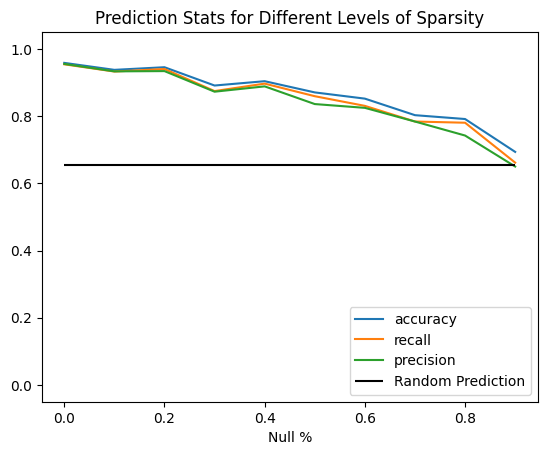

In [10]:
random_value = df.target.value_counts(normalize=True).max()

ax = prediction_stats_df.plot()
ax.set_ylim(-0.05, 1.05)
ax.hlines(y=random_value, xmin=0, xmax=0.9, color="black", label="Random Prediction")
ax.legend(loc="lower right")
ax.set_title("Prediction Stats for Different Levels of Sparsity")

plt.savefig("data/sparse_data_plot.png")